# Explore quantum models with a teacher-student scheme

This demonastration is based on the paper " Exploring Quantum Perceptrons and Quantum Neural Networks with a teacher-student scheme" by <a href="https://arxiv.org/abs/2105.01477" title="link">Aikaterini Gratsea and Patrick Huembeli</a>.

The paper introduces a teacher-student scheme to systematically compare different QNN architectures and to evaluate their relative expressive power. This scheme avoids training to a specific dataset and compares the learning capacity of different quantum models. 

## Introduction
We express the quantum models as variational quantum circuits with encoding and proccesing gates along with a measurement.

Here, we choose a two dimensional input data set with $ \vec{x}^k = ( x^k_1, x^k_2 ) $ and encode the data to the circuit with the gates $U(\vec{x}) = R_x (x_1) \otimes R_x (x_2)$ applied on two distinct qubits, where $R_x(\phi) = \exp( -i\phi \sigma_x/2 )$ is the single qubit $X$ rotation gate. These data encoding gates are depicted in light and dark orange colors respectively in the circuit diagrams below and we will refer to it as the angle encoding. Throughout this work, we use the same encoding for all models to have a fair comparison. 

The trainable part of the perceptron is realized by parameterized single qubit rotations $ Rot(\phi, \theta, \omega) = R_z(\omega)R_y(\theta)R_z(\phi)$ and controlled-Z gates. At the output of each quantum model we apply a multi-controlled NOT gate inspired by <a href="https://www.nature.com/articles/s41534-019-0140-4" title="link"> Tacchino et. al.</a>. The trainable gates are depicted in blue colors in the following figures and we will refer to them as processing gates.


To train the quantum model, we define the cost function
\begin{equation}\label{cost_function}
    C = \sum_k{ \left( y^k - \langle \psi^k \vert Z \vert \psi^k \rangle \right)^2 },
\end{equation}
which is minimized during the training.

## Teacher-student scheme

Even though many architectures have been introduced for the realization of quantum perceptrons, the direct comparison of them has not been performed. Here, we introduce the teacher-student scheme that aims to bridge this gap.

The main idea is that
one architecture (for example the dissipative quantum perceptron) will play the
role of the teacher and generate the labels that will be used
to train the student (for example the re-uploading quantum
model). In that way, we avoid to generate artificial data sets that could possibly favour
one of the architectures. With the teacher-student scheme we
directly see the data structures that each architecture can generate and how well these structures are learned from the other
architecture. 

In this tutorial, we systematically compare two architectures: the dissipative quantum perceptron and re-uploading quantum model inspired by the recents works of <a href="https://www.nature.com/articles/s41534-019-0140-4" title="link"> Tacchino et. al.</a> and <a href="https://arxiv.org/abs/1907.02085" title="link"> Pérez-Salinas et al.</a>, respectively. But, the scheme could be used for any circuits. 

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import matplotlib.pyplot as plt
import math
from sklearn.metrics import accuracy_score

## Quantum circuits

Here, we implement the quantum circuits at Fig.1 in our recent work (<a href="https://arxiv.org/abs/2105.01477" title="link">arXiv:2105.01477</a>).

## Teacher :: re-uploading quantum model
Fig. 1b

![alt text](QM.png "Title")

In [2]:
#The quantum circuit of the teacher (the re-uploading quantum model).
def qcircuit_teacher(params, x=None):

    for i in range (0, len(params), 2):
        #each layer i includes the encoding and processing gates

        qml.RX(x[0], wires = 0)
        qml.RX(x[1], wires = 1)

        qml.Rot(*params[i], wires=0)
        qml.Rot(*params[i+1], wires=1)
        if i < len(params):
            qml.CNOT(wires= [0, 1])

    qml.Toffoli(wires=[0,1,2])

    return qml.expval(qml.PauliZ(2))

## Student1 :: dissipative quantum perceptron
Fig. 1a

![alt text](QP.png "Title")

In [3]:
#The quantum circuit of student1.
def qcircuit_student1(params, x=None):

    #The encoding gates
    for i in range (0, len(x)):
        qml.RX(x[i], wires=i)

    #The processing gates
    for i in range (0, len(params)-1, 2):

        qml.Rot(*params[i], wires=0)
        qml.Rot(*params[i+1], wires=1)
        if i < len(params):
            qml.CNOT(wires= [0, 1])

    qml.Toffoli(wires=[0,1,2])

    return qml.expval(qml.PauliZ(2))

## Student2 :: re-uploading quantum model
Fig. 1b

![alt text](QM.png "Title")

In [4]:
#The quantum circuit of student2 is the same with the teacher.
def qcircuit_student2(params, x=None):

    for i in range (0, len(params), 2):
        #each layer i includes the encoding and processing gates

        qml.RX(x[0], wires = 0)
        qml.RX(x[1], wires = 1)

        qml.Rot(*params[i], wires=0)
        qml.Rot(*params[i+1], wires=1)
        if i < len(params):
            qml.CNOT(wires= [0, 1])

    qml.Toffoli(wires=[0,1,2])

    return qml.expval(qml.PauliZ(2))

## Tools for comparing the expressive power of the models

To identify a good/bad student all following metrics should be taken into account.

### 1. Contour plots for the data sets:

To gain qualitative results the $\it{prediction}$  $\it{maps}$ of the students are best for visualizing the similarity of the student's and teacher's predictions of the label $y^k$. 

In [5]:
def prediction_map(params, grid_resolution, qcircuit, rounded= False):
    #We create contour plots to visualize the teacher's and students' data sets.
    dec_map = np.zeros((grid_resolution, grid_resolution))
    x_line = np.linspace(-math.pi, math.pi , grid_resolution)
    X_grid, Y_grid = np.meshgrid(x_line, x_line)

    for i in range(grid_resolution):
        for j in range(grid_resolution):
            f = qcircuit(params, x=[x_line.tolist()[i], x_line.tolist()[j], 0])
            dec_map[j][i] = f
    
    if rounded == True:
        dec_map = np.sign(dec_map)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cont = ax.contourf(X_grid, Y_grid, dec_map, 20, cmap='magma')
    plt.colorbar(cont)

### 2. Loss curves:

Another qualitative metric is the $\it{loss}~\it{function}$ which determines the success of the training.

In [6]:
def cost(params, x, y, qcircuit):
    #Cost function to be minimized
    loss = 0.0
    for i in range(0, len(x)):
        f = qcircuit(params, x=x[i])
        loss += (y[i] - f) ** 2
        
    return loss / len(x)

def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

def train_student(parameters_student, teacher_labels, x, qnode, Epochs, Batch_size, loss_list):
    for it in range(Epochs):
        loss = cost(parameters_student, x, teacher_labels, qnode)
        loss_list.append(loss)
    
        for Xbatch, ybatch in iterate_minibatches(x, teacher_labels, Batch_size):
            parameters_student = opt.step(lambda v: cost(v, Xbatch, ybatch, qnode), parameters_student)

    return(parameters_student, loss_list)

In [7]:
def cost(params, x, y, qcircuit):
    #Cost function to be minimized
    loss = 0.0
    for i in range(0, len(x)):
        f = qcircuit(params, x=x[i])
        loss += (y[i] - f) ** 2
       
    return loss / len(x)

### 3. Accuracy score: 

When the student is trained with the binary valued labels the percentage of the correctly predicted labels can be computed. We refer to this as the $\it{accuracy}~\it{score}$ which gives an overall performance of the student.

In [8]:
def training_accuracy(teacher_rounded_labels, student_params, x, qnode):
    y_predicted_rounded = []
    for i in range (0, len(x)):
        value = qnode(student_params, x=X_train[i])
        if (value > 0) :
            y_predicted_rounded.append(1)
        else:
            y_predicted_rounded.append(-1)
    student_y_train_rounded = np.array(y_predicted_rounded)
    accuracy_trainingI = accuracy_score(teacher_rounded_labels, student_y_train_rounded)
    return (accuracy_trainingI)

### 4. Relative entropy: 

For a more rigorous quantitative comparison we compute the $\it{relative}$ $\it{entropy}$ between the student's and teacher's outputs $y^k$. Specifically, we use the information divergence (or relative entropy) which defines a distinguisability measure between two probability distributions $P$ and $Q$ (see <a href="https://doi.org/10.1017/CBO9780511535048" title="link"> Geometry of Quantum States</a>): 
\begin{align}
S(P \| Q)=\sum_{i=1}^{N} p_{i} \ln \dfrac{p_{i}}{q_{i}}.
\end{align}
When the two distributions are similar, the value of the relative entropy is close to zero. To interpret the predicted labels $y^k$ as probabilities, we offset and re-normalize them ($y^k>0$, $\sum_{\vec{x^k}\in \mathcal{D}} y^k = 1 $). Then, to compare two prediction maps, the information divergence is calculated by summing over the whole input space. 

In [9]:
def prediction_map_rescaled(params, grid_resolution, qcircuit, rounded= False):
    #rescaled prediction maps to compute the relative entropy
    dec_map = np.zeros((grid_resolution, grid_resolution))
    x_line = np.linspace(-math.pi, math.pi , grid_resolution)
    X_grid, Y_grid = np.meshgrid(x_line, x_line)

    min_map = 1
    max_map = 0
    for i in range(grid_resolution):
        for j in range(grid_resolution):
            f = qcircuit(params, x=[x_line.tolist()[i], x_line.tolist()[j], 0])
            dec_map[j][i] = f
            if f < min_map:
                min_map = f
            if f > max_map:
                max_map = f
    if rounded == True:
        dec_map = np.sign(dec_map)

    epsilon = 0.0001
    dec_map -= min_map + epsilon
    dec_map /= (max_map-min_map)
    dec_map /= dec_map.sum()
    return (abs(dec_map))

def Relative_entropy(grid_resolution, map1, map2):
    map_RE1 = np.zeros((grid_resolution, grid_resolution))
    RE1 = 0
    for i in range(grid_resolution):
        for j in range(grid_resolution):
            map_RE1[i][j] = map1[i][j]*math.log(map1[i][j]/map2[i][j])
            RE1 += map_RE1[i][j]
    return (RE1)

In [10]:
#number of processing gates for the teacher and the students
nr_of_gates_teacher = 4 
nr_of_gates = 4
trainings = 1
#number of data points
inputs = 500

dev = qml.device("default.qubit", wires=3)

list_teacher_params = []
list_student1_params = []
list_student2_params = []

list_student1_params_rounded = []
list_student2_params_rounded = []

### The teacher

The teacher generates arbitrary data-sets that are to be learned by the students. Different realizations for the teachers were considered in our recent work, but here we use just a single teacher for simplicity. To identify a good/bad student all the aforementioned tools should be taken into account. Each teacher generates a data-set with continious values for the labels $y^k \in [-1, 1]$, but we also generate binary valued labels by choosing $ y^k_{\text{binary}} = \text{sign} (y^k)$ (reffered to as rounded labels). We visualize the data sets with the prediction maps.

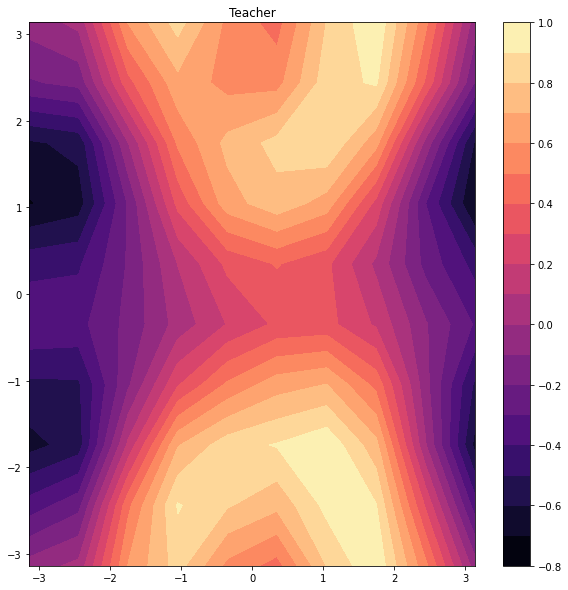

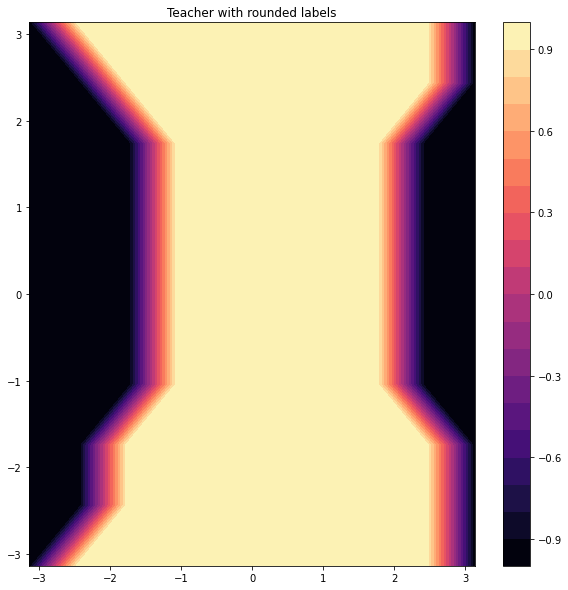

In [11]:
#Set a random seed
np.random.seed(42)
qnode_teacher = qml.QNode(qcircuit_teacher, dev)

def circle(samples, center=[0.0, 0.0], radius=np.sqrt(4)):
    #Data points inside and outside a given radius with the labels 1 and -1, respectively.
    dataX, dataY = [], []

    for i in range(samples):
        x = 2 * math.pi * (np.random.rand(2)) - math.pi
        y = 1
        if np.linalg.norm(x - center) < radius:
            y = -1
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)

positivity = 0.8
#Guarantess that the number of labels "1" are less than 80%.
while (positivity >= 0.8):
        positivity = 0
        #Define random parameters for the proccessing gates of the teacher.
        params_teacher = 2*np.pi*np.random.rand(nr_of_gates_teacher, 3)

        #The proccessing gates change the circular data-set to a more complex one.
        X_train, y_train = circle(inputs)
        
        list_labels = []
        list_labels_rounded = []
        for i in range (0, inputs):
            list_labels.append(qnode_teacher(params_teacher, x=X_train[i]))
            if (list_labels[i] >= 0) :
                list_labels_rounded.append(1)
                positivity += 1
            else:
                list_labels_rounded.append(-1)
        positivity /= inputs

list_teacher_params.append(params_teacher.tolist())

teacher_y_train = np.tensor(list_labels)
teacher_y_train_rounded = np.tensor(list_labels_rounded)

the_map = prediction_map(params_teacher, 10, qnode_teacher)
plt.title("Teacher" )
plt.show()
plt.close()

the_map_rounded = prediction_map(params_teacher, 10, qnode_teacher, True)
plt.title("Teacher with rounded labels")
plt.show()
plt.close()

In [12]:
params_teacher

tensor([[2.71445498, 6.15983847, 0.42413101],
        [3.25909447, 1.12698153, 6.09894061],
        [0.71190692, 2.53589989, 4.6362681 ],
        [4.42684603, 2.65608236, 2.17727556]], requires_grad=True)

# Training parameters

In [13]:
learning_rate = 0.1
epochs = 20
batch_size = 32
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

### Training of Student1 (fig.1a)

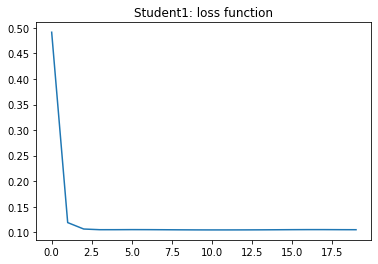

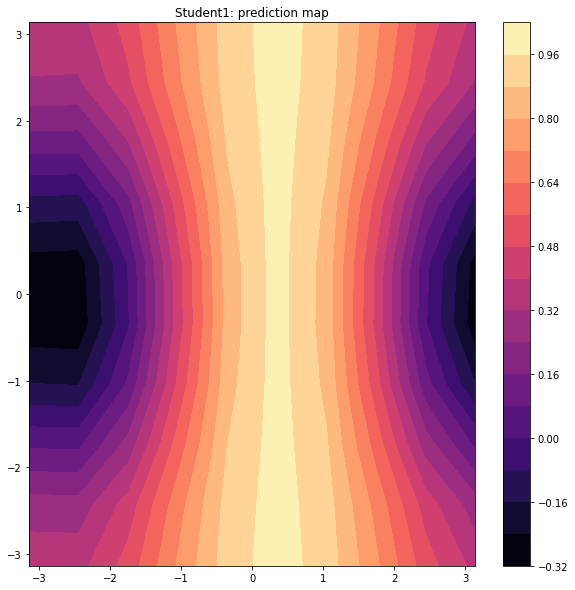

In [14]:
qnode_student1 = qml.QNode(qcircuit_student1, dev)
params_student1 = np.random.uniform(size=(nr_of_gates, 3))
loss_list1 = []

params_student1, loss_list1 = train_student(params_student1, teacher_y_train, X_train, qnode_student1, epochs, 10, loss_list1)

plt.plot(loss_list1)
plt.title("Student1: loss function")
plt.show()
plt.close()  

the_map = prediction_map(params_student1, 10, qnode_student1)
plt.title("Student1: prediction map")
plt.show()
plt.close()

In [15]:
print (params_student1)

[[-1.21932501e+00  3.83209792e-01  7.72353356e-01]
 [ 2.20380734e+00  4.21354325e+00  1.11910696e+00]
 [ 6.17437019e-01  2.40264471e-03  8.18380427e-01]
 [-4.07639417e-01  8.30295036e-01  9.91962752e-01]]


#### Relative entropy

In [16]:
mapT = prediction_map_rescaled(params_teacher, 10, qnode_teacher)
mapS1 = prediction_map_rescaled(params_student1, 10, qnode_student1)

rel_entropy1 = Relative_entropy(10, mapT, mapS1) 
str_rel_entropy1 = str(round(float(rel_entropy1), 2))
print ("The relative entropy is approximately equal to " + str_rel_entropy1 + ".")

The relative entropy is approximately equal to 0.11.


#### The dissipative QP (student 1) does not learn the inner structure (circles) at the left and right sides of the prediction map of the teacher which is in accordance with the non-zero relative entropy.

### Training of Student2 (fig.1b)

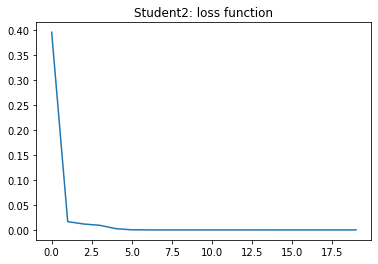

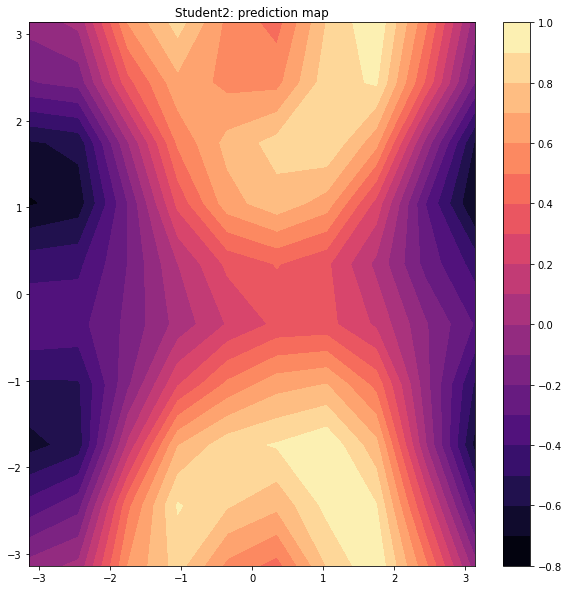

In [17]:
qnode_student2 = qml.QNode(qcircuit_student2, dev)
params_student2 = np.random.uniform(size=(nr_of_gates, 3))
loss_list2 = []

params_student2, loss_list2 = train_student(params_student2, teacher_y_train, X_train, qnode_student2, epochs, 10, loss_list2)

plt.plot(loss_list2)
plt.title("Student2: loss function")
plt.show()
plt.close()  

the_map = prediction_map(params_student2, 10, qnode_student2)
plt.title("Student2: prediction map")
plt.show()
plt.close()

In [18]:
print (params_student2)

[[-1.29812291  0.40474697 -1.86097443]
 [ 0.60238058  1.88735715  0.37064767]
 [ 0.17131456  2.69266775  0.6738389 ]
 [ 0.49481106 -0.14269316  0.67648375]]


#### Relative entropy

In [19]:
mapT = prediction_map_rescaled(params_teacher, 10, qnode_teacher)
mapS2 = prediction_map_rescaled(params_student2, 10, qnode_student2)

rel_entropy2 = Relative_entropy(10, mapT, mapS2) 
str_rel_entropy2 = str(round(float(rel_entropy2), 2))
print ("The relative entropy is approximately equal to " + str_rel_entropy2 + ".")

The relative entropy is approximately equal to 0.0.


#### The reuploading quantum model (student 2) reproduces almost perfectly the teacher as expected (since they have the same circuit architecture) which is in accordance with the zero relative entropy.

### Training of Student1 with rounded labels

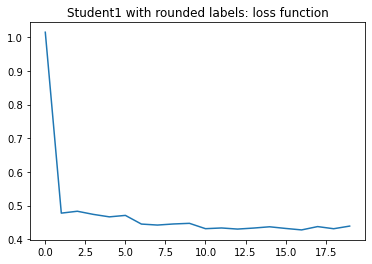

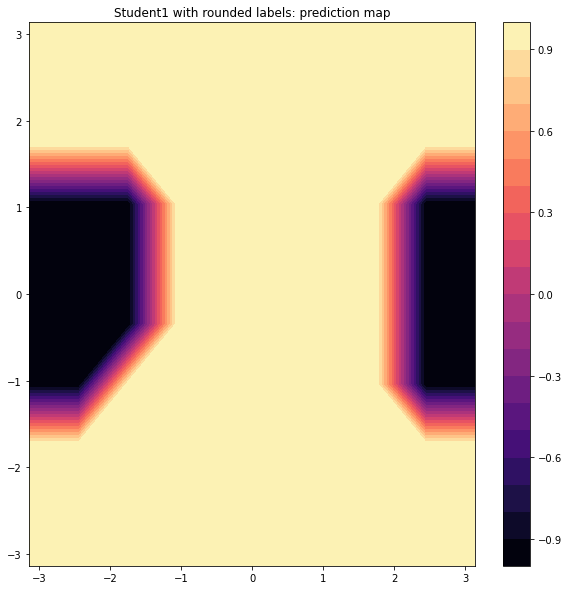

In [20]:
qnode_student1 = qml.QNode(qcircuit_student1, dev)
params_student1_rounded = np.random.uniform(size=(nr_of_gates, 3))
loss_list1_rounded = []

params_student1_rounded, loss_list1_rounded = train_student(params_student1_rounded, teacher_y_train_rounded, X_train, qnode_student1, epochs, 10, loss_list1_rounded)

plt.plot(loss_list1_rounded)
plt.title("Student1 with rounded labels: loss function")
plt.show()
plt.close()

map_rounded = prediction_map(params_student1_rounded, 10, qnode_student1, True)
plt.title("Student1 with rounded labels: prediction map")
plt.show()
plt.close()

In [21]:
print (params_student1_rounded)

[[-1.60247603  0.2201697  -2.29260286]
 [ 0.22478436 -2.83845341  0.21297577]
 [-2.06483314  0.13616009  0.69235431]
 [-0.1532694  -0.07581228  0.74707827]]


#### Accuracy score

In [22]:
acc = training_accuracy(teacher_y_train_rounded, params_student1_rounded, X_train, qnode_student1 )
str_acc = str(acc)
print ("The accuracy score is " + str_acc + ".")

The accuracy score is 0.866.


### Training of Student2 with rounded labels

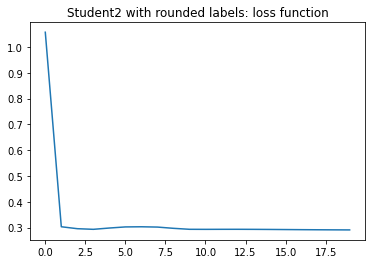

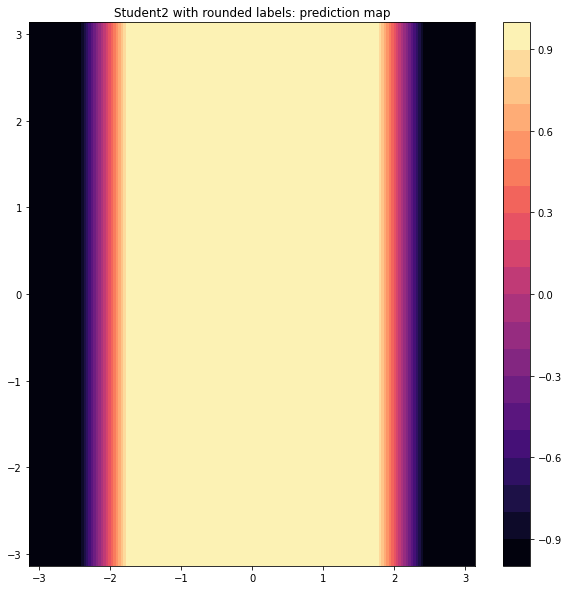

In [23]:
qnode_student2 = qml.QNode(qcircuit_student2, dev)
params_student2_rounded = np.random.uniform(size=(nr_of_gates, 3))
loss_list2_rounded = []

params_student2_rounded, loss_list2_rounded = train_student(params_student2_rounded, teacher_y_train_rounded, X_train, qnode_student2, epochs, 10, loss_list2_rounded)

plt.title("Student2 with rounded labels: loss function")
plt.plot(loss_list2_rounded)
plt.show()
plt.close()

map_rounded = prediction_map(params_student2_rounded, 10, qnode_student2, True)
plt.title("Student2 with rounded labels: prediction map")
plt.show()
plt.close()

In [24]:
print (params_student2_rounded)

[[ 2.39157018 -0.07956169  1.43036795]
 [ 0.15843496  2.52473217  0.17502811]
 [ 1.05972403  2.92416985  0.47852837]
 [ 2.05761075 -0.02017417  0.46533693]]


#### Accuracy score

In [25]:
acc = training_accuracy(teacher_y_train_rounded, params_student2_rounded, X_train, qnode_student2 )
str_acc = str(acc)
print ("The accuracy score is " + str_acc + ".")

The accuracy score is 0.91.


### Discussion

The loss curves for both students converge to low values and verify the success of the training. Student 2 (re-uploading quantum model) converges to a lower value compared to student 1 (dissipative QP), which is in agreement with the comparison of the prediction maps. 

Student 2 reproduces almost perfectly the prediction map of the teacher, contrary to student 1 which reproduces a simplified version of the prediction map of the teacher. 

If we use the binary labels of the teacher and train again the students we reach the accuracy score approximately equal to 0.9 for the quantum model compared to 0.8 for the dissipative quantum perceptron, which again shows that student 2 (the quantum model) performs better. 

These results are also supported by the calculation of the average relative entropy over all prediction maps of different teacher's realizations which is equal to ''0.247'' and ''0.001'' for the dissipative quantum perceptron (student 1) and the re-uploading quantum model (student 2), respectively.

### Concluding remarks

To complete the comparison between the models, the dissipative quantum model should play the role of the teacher as well. Morevoer, one should generate different realizations of the teachers, train the students and get the average performance for the loss, accuracy score and relative entropy. 

In this tutorial, we  have demonastrated the teacher-student scheme which systematically compares any quantum models. We have stretched the difficulty on how to determine whether a student is good or bad. Therefore,
one should take under consideration all the different tools introduced earlier (the prediction maps, the loss, the accuracy score and relative entropy) to characterize the performance of the students.